In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json

# Útvonal beállítása
DATA_DIR = "../data" if os.path.exists("../data") else "/app/data"
print(f"Adatok könyvtára: {DATA_DIR}")

# CSV fájlok keresése minden alkönyvtárban
# A glob '**/*.csv' rekurzívan keres, ha a recursive=True be van állítva
csv_files = glob.glob(os.path.join(DATA_DIR, "**", "*.csv"), recursive=True)

print(f"Összesen {len(csv_files)} CSV fájlt találtunk.")

# Opcionális: Lista kiírása (csak az első 5-öt, hogy ne szemetelje tele a kimenetet)
for f in csv_files[:5]:
    # A relatív utat írjuk ki a DATA_DIR-hez képest
    rel_path = os.path.relpath(f, DATA_DIR)
    print(f" - {rel_path}")
if len(csv_files) > 5:
    print(f" ... és további {len(csv_files)-5} db.")


Adatok könyvtára: ../data
Összesen 235 CSV fájlt találtunk.
 - clean_EURUSD_1H_040.csv
 - clean_EURUSD_15m_006.csv
 - clean_EURUSD_5min_040.csv
 - clean_EURUSD_1min_004.csv
 - clean_EURUSD_1H_056.csv
 ... és további 230 db.


--------------------------------------------------


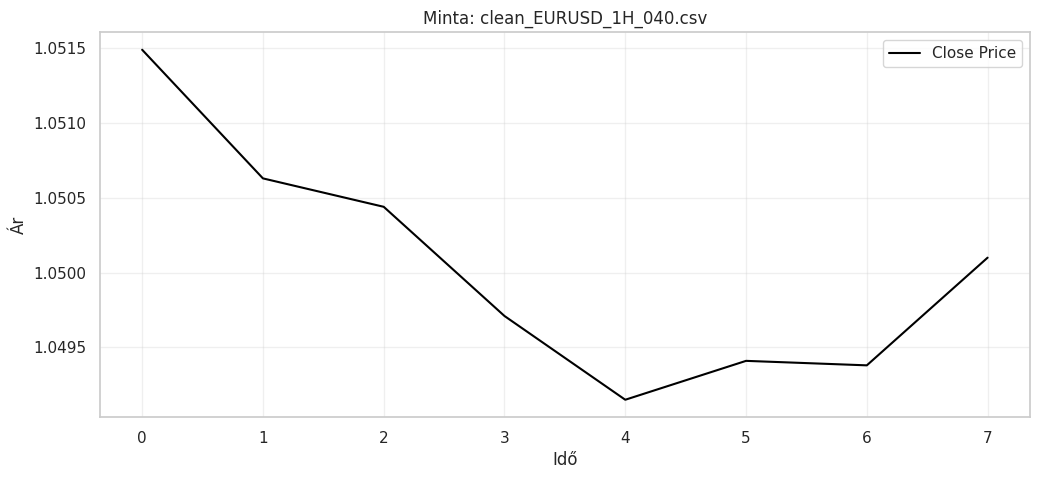

Fájl: ../data/clean_EURUSD_1H_040.csv
Méret: 8 sor
--------------------------------------------------


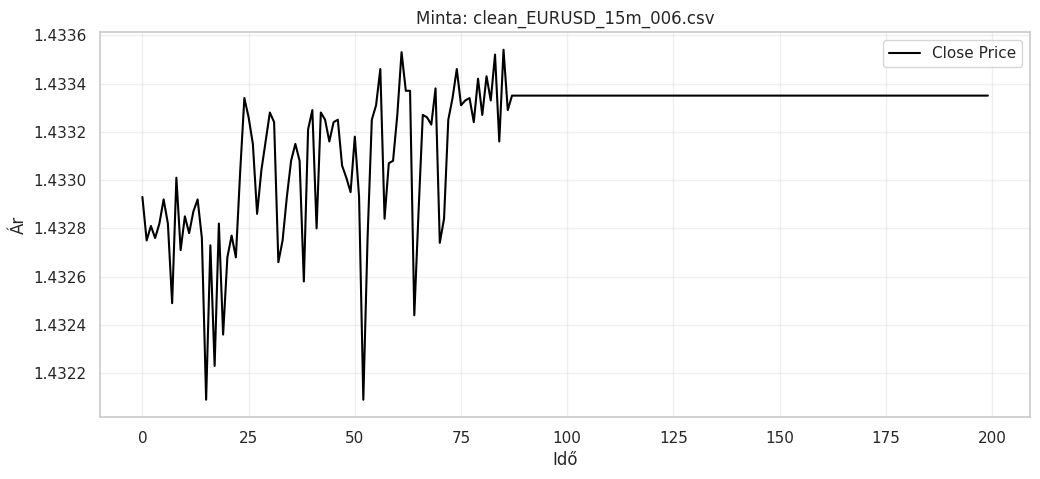

Fájl: ../data/clean_EURUSD_15m_006.csv
Méret: 245388 sor
--------------------------------------------------


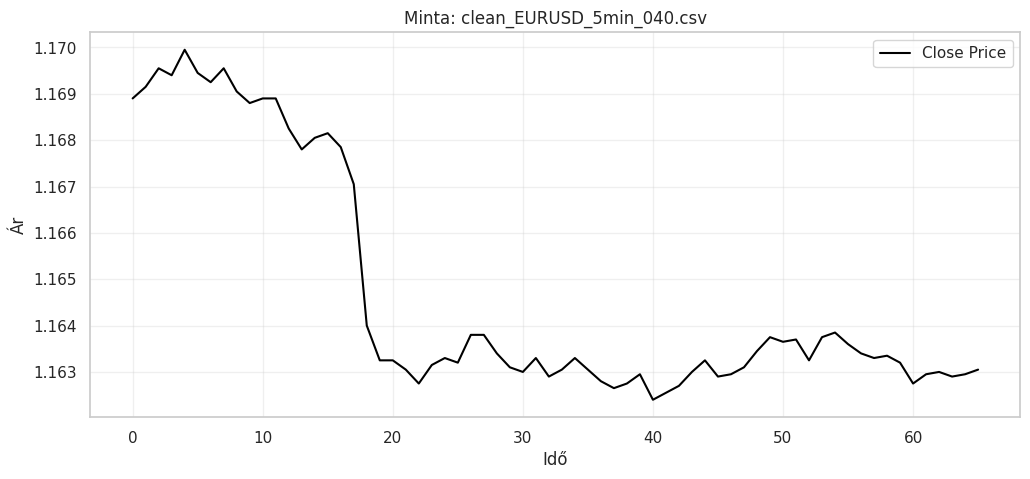

Fájl: ../data/clean_EURUSD_5min_040.csv
Méret: 66 sor


In [14]:
def plot_sample(file_path):
    """Betölt egy CSV-t és kirajzolja az első 200 gyertyát."""
    try:
        df = pd.read_csv(file_path)
        # Oszlopnevek egységesítése
        df.columns = [c.capitalize() for c in df.columns]

        if 'Timestamp' in df.columns:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp').sort_index()

        plt.figure(figsize=(12, 5))
        # Ellenőrzés, hogy van-e adat
        if len(df) > 0:
            cols_to_plot = 'Close' if 'Close' in df.columns else df.columns[0]
            plt.plot(df.index[:200], df[cols_to_plot][:200], label='Close Price', color='black')

        plt.title(f"Minta: {os.path.basename(file_path)}")
        plt.xlabel("Idő")
        plt.ylabel("Ár")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        print(f"Fájl: {file_path}")
        print(f"Méret: {len(df)} sor")
    except Exception as e:
        print(f"Hiba a {file_path} betöltésekor: {e}")

# Minta kirajzolása az első 3 talált fájlból
for f in csv_files[:3]:
    print("-" * 50)
    plot_sample(f)

--------------------------------------------------


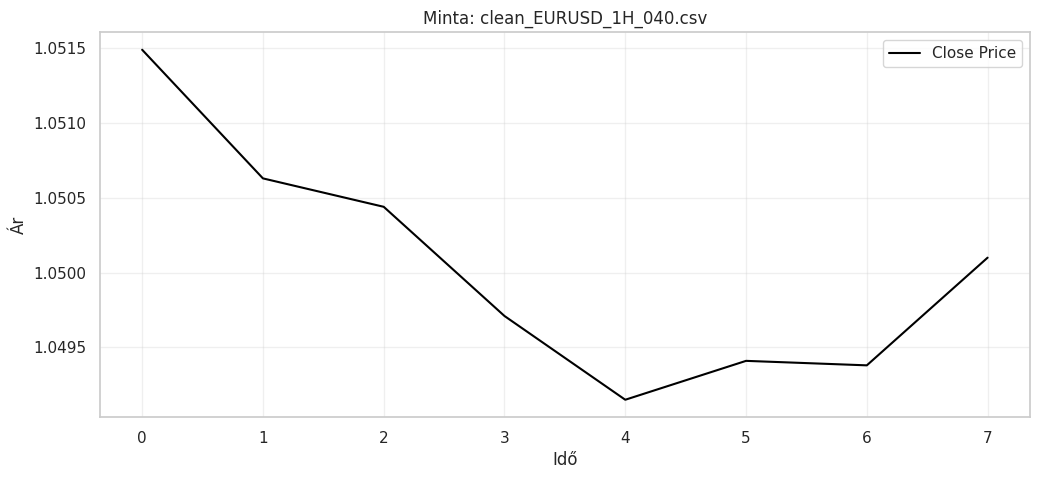

Fájl: ../data/clean_EURUSD_1H_040.csv
Méret: 8 sor
--------------------------------------------------


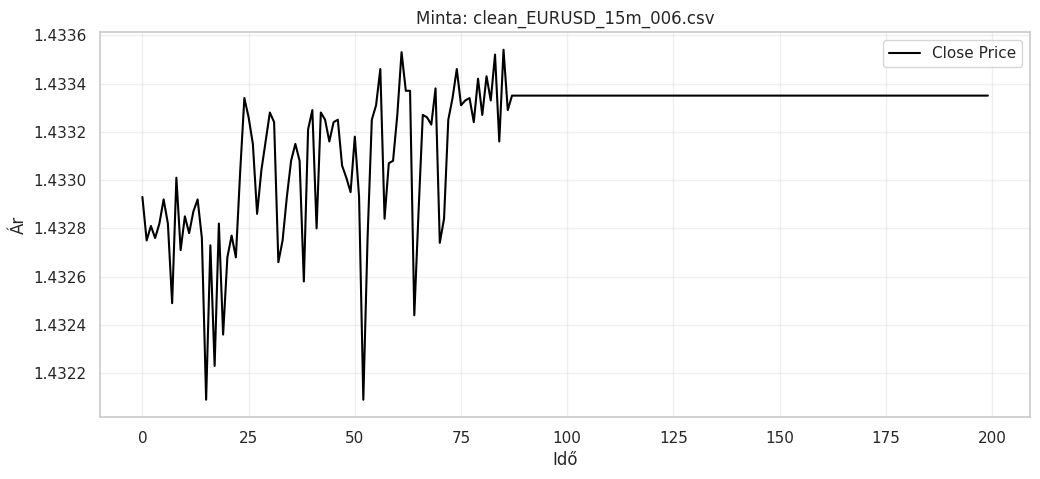

Fájl: ../data/clean_EURUSD_15m_006.csv
Méret: 245388 sor
--------------------------------------------------


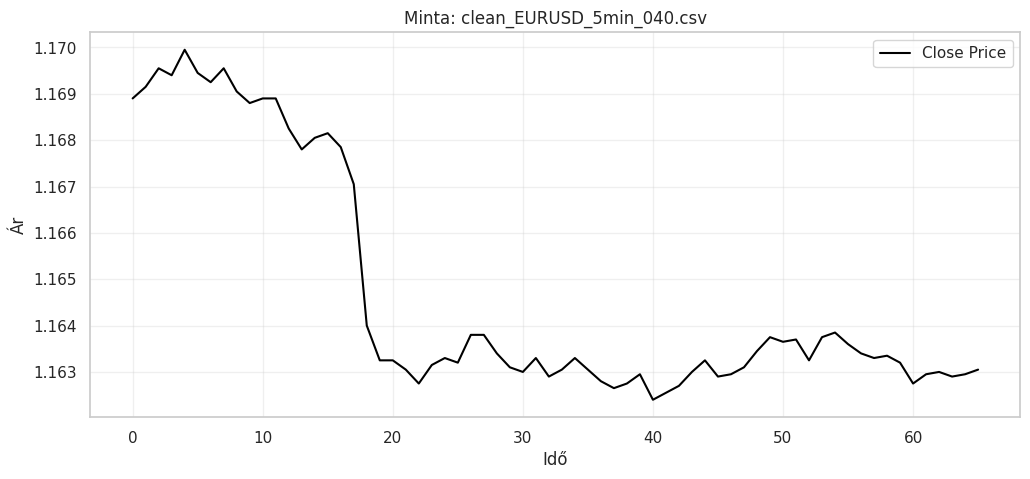

Fájl: ../data/clean_EURUSD_5min_040.csv
Méret: 66 sor


In [15]:
def robust_parse_dates(df):
    """
    Javított dátumfelismerés DataFrame oszlopra.
    Kezeli a Unix timestamp-et (s/ms) és string dátumokat is.
    """
    col_map = {c.lower(): c for c in df.columns}
    ts_col = col_map.get('timestamp') or col_map.get('time') or col_map.get('date')

    if not ts_col:
        return df

    # Próbáljuk meg numerikussá alakítani
    temp_col = pd.to_numeric(df[ts_col], errors='coerce')

    # Ha a többség szám (Unix timestamp)
    if temp_col.notna().sum() > len(df) * 0.8:
        temp_col = temp_col.ffill().bfill()
        first_val = temp_col.iloc[0]

        # > 3e10 (kb 1971-es év másodpercben) -> valószínűleg ms
        if first_val > 3e10:
            df[ts_col] = pd.to_datetime(temp_col, unit='ms')
        else:
            df[ts_col] = pd.to_datetime(temp_col, unit='s')
    else:
        df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')

    df = df.set_index(ts_col).sort_index()
    return df

def plot_sample(file_path):
    """Betölt egy CSV-t és kirajzolja az első 200 gyertyát."""
    try:
        df = pd.read_csv(file_path)
        # Oszlopnevek egységesítése
        df.columns = [c.capitalize() for c in df.columns]

        # --- JAVÍTOTT RÉSZ ---
        df = robust_parse_dates(df)
        # ---------------------

        plt.figure(figsize=(12, 5))
        # Ellenőrzés, hogy van-e adat
        if len(df) > 0:
            cols_to_plot = 'Close' if 'Close' in df.columns else df.columns[0]
            plt.plot(df.index[:200], df[cols_to_plot][:200], label='Close Price', color='black')

        plt.title(f"Minta: {os.path.basename(file_path)}")
        plt.xlabel("Idő")
        plt.ylabel("Ár")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        print(f"Fájl: {file_path}")
        print(f"Méret: {len(df)} sor")
    except Exception as e:
        print(f"Hiba a {file_path} betöltésekor: {e}")

# Minta kirajzolása az első 3 talált fájlból
for f in csv_files[:3]:
    print("-" * 50)
    plot_sample(f)

In [16]:
def parse_annotation_time(time_val):
    """
    Egyetlen JSON időérték biztonságos parse-olása.
    """
    if time_val is None:
        return None
    try:
        numeric_ts = float(time_val)
        if numeric_ts > 3e10:
            return pd.to_datetime(numeric_ts, unit='ms')
        else:
            return pd.to_datetime(numeric_ts, unit='s')
    except (ValueError, TypeError):
        return pd.to_datetime(time_val)

def find_csv_path_recursive(filename, root_dir):
    """Megkeresi a fájlt a root_dir alatt bárhol."""
    matches = glob.glob(os.path.join(root_dir, "**", filename), recursive=True)
    if matches: return matches[0]

    simple_name = filename.split('-')[-1] if '-' in filename else filename
    all_csvs = glob.glob(os.path.join(root_dir, "**", "*.csv"), recursive=True)
    for f in all_csvs:
        if os.path.basename(f).endswith(simple_name) or simple_name in os.path.basename(f):
            return f
    return None

def visualize_all_patterns():
    # Labels.json fájlok keresése - itt is a javított logikával
    all_tasks = []

    # Mappák bejárása JSON fájlokért (függetlenül a nevüktől)
    for root, dirs, files in os.walk(DATA_DIR):
        for file in files:
            if file.endswith(".json"):
                full_path = os.path.join(root, file)
                try:
                    with open(full_path, 'r') as f:
                        tasks = json.load(f)
                        for t in tasks: t['_source_dir'] = root
                        all_tasks.extend(tasks)
                except Exception as e:
                    print(f"Hiba a {full_path} olvasásakor: {e}")

    targets = {
        "Bullish Normal": False, "Bullish Pennant": False, "Bullish Wedge": False,
        "Bearish Normal": False, "Bearish Pennant": False, "Bearish Wedge": False
    }

    print(f"Összesen {len(all_tasks)} task feldolgozása a mintákhoz...")

    for task in all_tasks:
        if all(targets.values()): break

        filename = task.get('file_upload')
        if not filename: continue

        csv_path = find_csv_path_recursive(filename, DATA_DIR)

        if not csv_path: continue

        df = None # Lazy load

        for ann in task.get('annotations', []):
            for res in ann.get('result', []):
                val = res.get('value', {})
                labels = val.get('timeserieslabels', [])
                if not labels: continue

                original_label = labels[0]

                direction = "Bullish" if "Bullish" in original_label else ("Bearish" if "Bearish" in original_label else None)
                shape = "Normal"
                if "Pennant" in original_label: shape = "Pennant"
                elif "Wedge" in original_label: shape = "Wedge"

                if not direction: continue
                target_key = f"{direction} {shape}"

                if target_key in targets and not targets[target_key]:
                    if df is None:
                        try:
                            df = pd.read_csv(csv_path)
                            df.columns = [c.capitalize() for c in df.columns]

                            # --- JAVÍTOTT RÉSZ ---
                            df = robust_parse_dates(df)
                            # ---------------------
                        except: break

                    # --- JAVÍTOTT RÉSZ ---
                    start = parse_annotation_time(val.get('start'))
                    end = parse_annotation_time(val.get('end'))
                    # ---------------------

                    if start is None or end is None: continue

                    margin = pd.Timedelta(minutes=30)

                    mask = (df.index >= start - margin) & (df.index <= end + margin)
                    subset = df.loc[mask]

                    if len(subset) > 0:
                        plt.figure(figsize=(10, 4))
                        plt.plot(subset.index, subset['Close'], color='gray', alpha=0.5, label='Context')

                        pat_mask = (subset.index >= start) & (subset.index <= end)
                        plt.plot(subset.loc[pat_mask].index, subset.loc[pat_mask]['Close'],
                                 color='green' if direction == "Bullish" else 'red', linewidth=2, label=target_key)

                        plt.title(f"{target_key} | {os.path.basename(csv_path)}")
                        plt.legend()
                        plt.show()
                        targets[target_key] = True
                        print(f"✅ {target_key} found.")

visualize_all_patterns()

Összesen 0 task feldolgozása a mintákhoz...


Összesen 552 annotált minta van az adatbázisban.


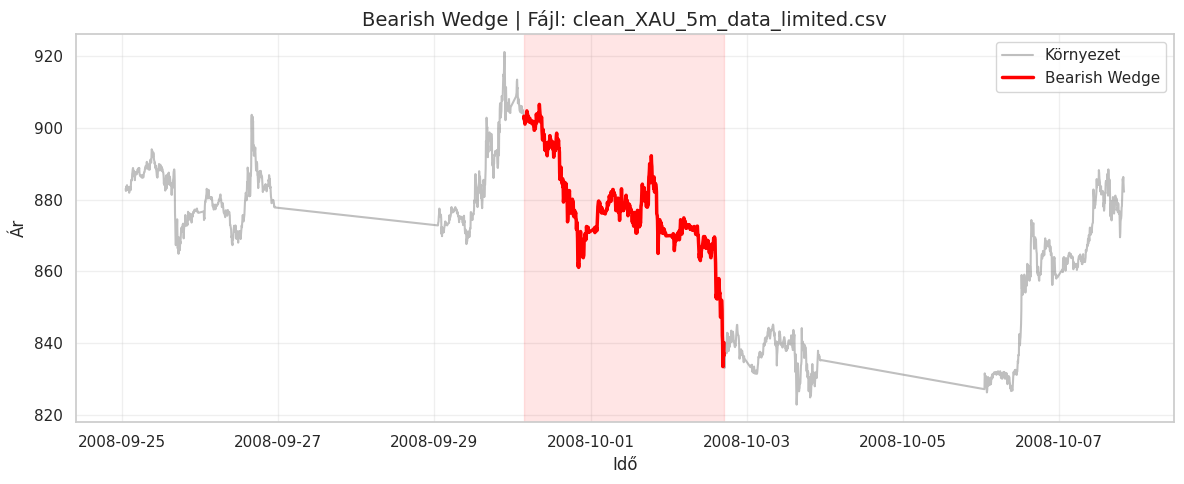

✅ Bearish Wedge kirajzolva.


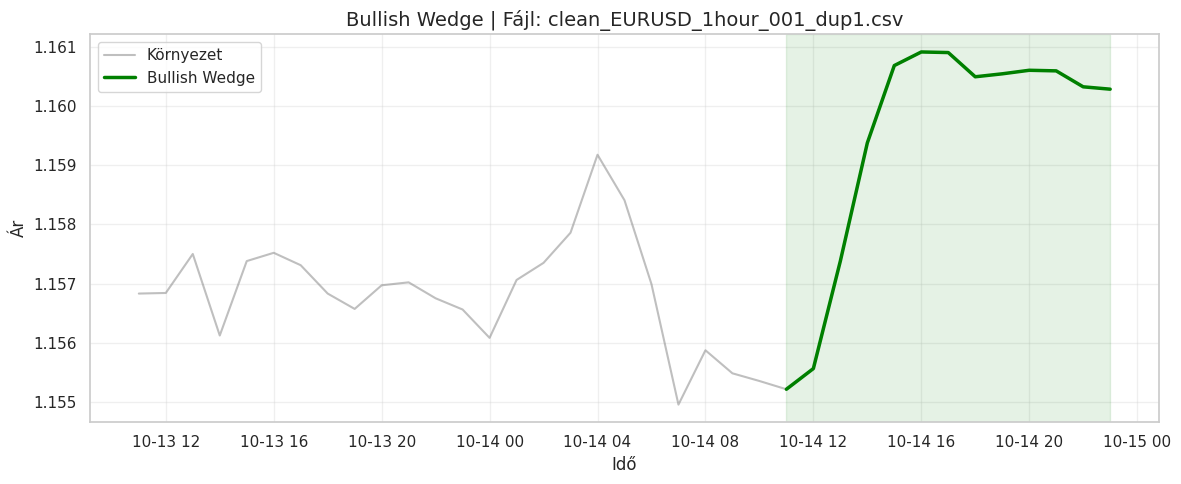

✅ Bullish Wedge kirajzolva.


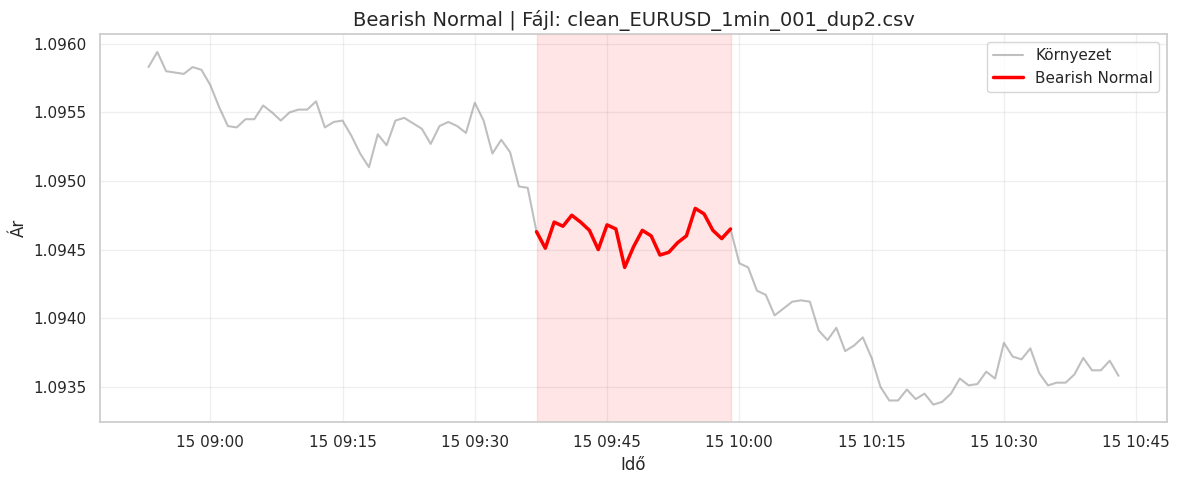

✅ Bearish Normal kirajzolva.


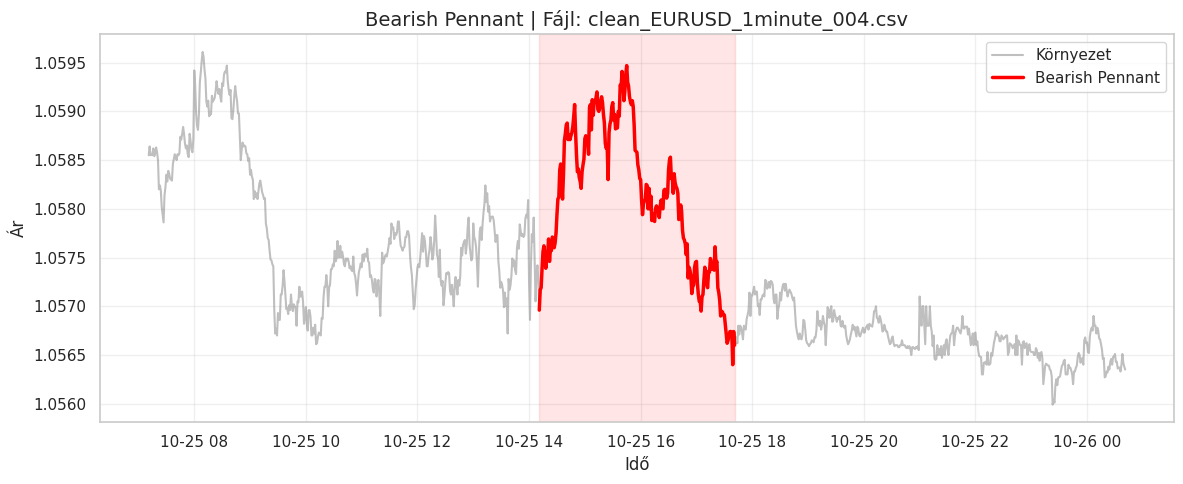

✅ Bearish Pennant kirajzolva.


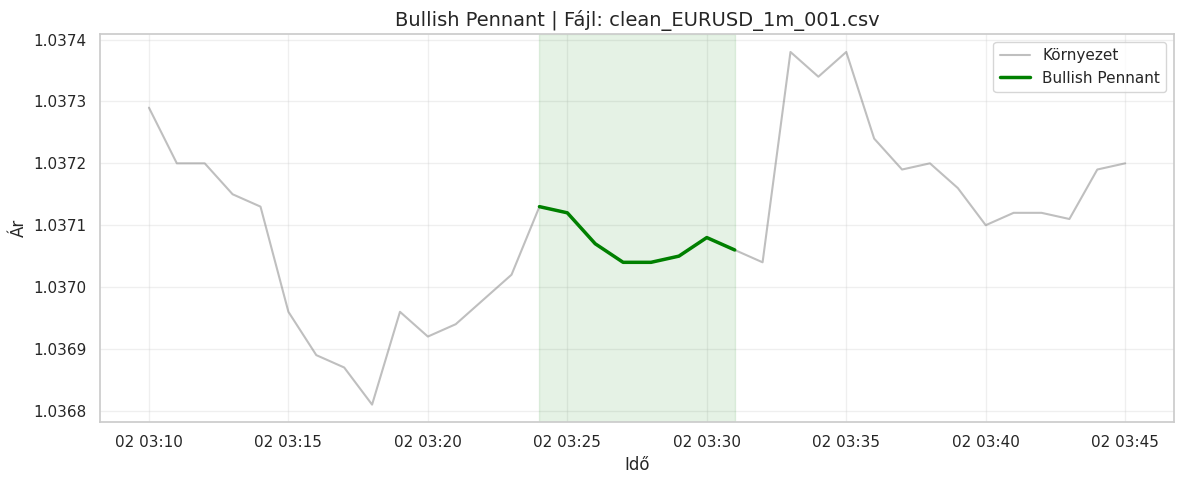

✅ Bullish Pennant kirajzolva.


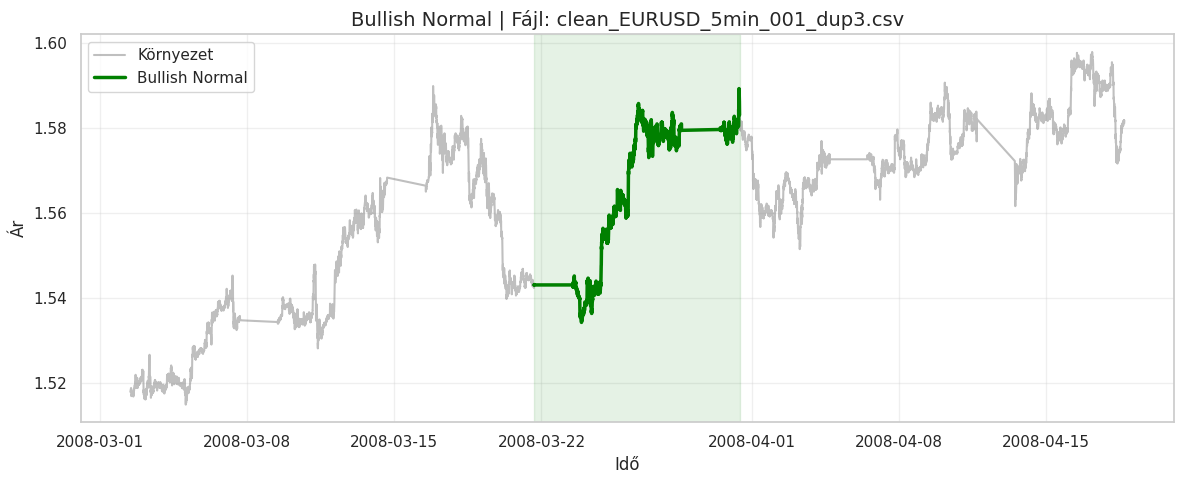

✅ Bullish Normal kirajzolva.
Minden típust megtaláltunk!


In [19]:
# ... (A korábbi importok és setup maradhat) ...

def visualize_all_patterns():
    # Ellenőrizzük, hogy megvan-e a label fájl
    if not os.path.exists(config.LABEL_FILE):
        print(f"HIBA: Nincs meg a fájl: {config.LABEL_FILE}")
        return

    df_labels = pd.read_csv(config.LABEL_FILE)
    df_labels = df_labels.dropna(subset=['clean_csv_filename'])

    print(f"Összesen {len(df_labels)} annotált minta van az adatbázisban.")

    targets = {
        "Bullish Normal": False, "Bullish Pennant": False, "Bullish Wedge": False,
        "Bearish Normal": False, "Bearish Pennant": False, "Bearish Wedge": False
    }

    # Véletlenszerű sorrend
    df_shuffled = df_labels.sample(frac=1, random_state=42).reset_index(drop=True)

    for _, row in df_shuffled.iterrows():
        if all(targets.values()):
            print("Minden típust megtaláltunk!")
            break

        label_type = row['label']
        if label_type not in targets or targets[label_type]:
            continue

        filename = row['clean_csv_filename']
        csv_path = os.path.join(config.DATA_ROOT, filename)

        if not os.path.exists(csv_path):
            continue

        try:
            # --- JAVÍTOTT BETÖLTÉS (Training módszer) ---
            # 1. index_col=0: Az első oszlop az index (idő)
            # 2. parse_dates=True: Próbálja meg dátumként értelmezni
            df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

            # --- BIZTOSÍTÉK ---
            # Ha véletlenül mégsem DatetimeIndex lenne (pl. string maradt), kényszerítjük:
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index, utc=True)

            # Időzóna törlése (hogy összehasonlítható legyen a Label fájl sima dátumaival)
            df.index = df.index.tz_localize(None)

            # Oszlopnevek egységesítése
            df.columns = [c.capitalize() for c in df.columns] # Open, High, Low, Close...

            # --- VÉGE A BETÖLTÉSNEK ---

            # Időpontok a label fájlból
            # A label fájlban lévő dátumokat is biztosan dátummá alakítjuk
            start_ts = pd.to_datetime(row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts'])
            end_ts = pd.to_datetime(row['flag_end_ts'])

            # Margin (környezet)
            duration = end_ts - start_ts
            margin = duration * 2

            plot_start = start_ts - margin
            plot_end = end_ts + margin

            # Kivágás
            subset = df.loc[(df.index >= plot_start) & (df.index <= plot_end)]

            if len(subset) == 0:
                # Ha üres, lehet, hogy a label dátum rossz, vagy a fájlban nincs ott adat
                continue

            # Plotolás
            plt.figure(figsize=(12, 5))

            # Melyik oszlopot rajzoljuk? (Close vagy close)
            plot_col = 'Close' if 'Close' in subset.columns else subset.columns[0]

            plt.plot(subset.index, subset[plot_col], color='gray', alpha=0.5, label='Környezet')

            pattern_subset = subset.loc[(subset.index >= start_ts) & (subset.index <= end_ts)]

            color = 'green' if 'Bullish' in label_type else 'red'
            plt.plot(pattern_subset.index, pattern_subset[plot_col], color=color, linewidth=2.5, label=label_type)

            plt.axvspan(start_ts, end_ts, color=color, alpha=0.1)

            plt.title(f"{label_type} | Fájl: {filename}", fontsize=14)
            plt.legend()
            plt.xlabel("Idő")
            plt.ylabel("Ár")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            targets[label_type] = True
            print(f"✅ {label_type} kirajzolva.")

        except Exception as e:
            # Csak akkor írjuk ki, ha tényleg baj van, de a 'continue'-k miatt a kisebb hibákat átugorja
            print(f"Hiba a {filename} feldolgozásakor: {e}")

# Futtatás
visualize_all_patterns()